# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans                          # K Means
from sklearn.cluster import AgglomerativeClustering         # Hierarchical Agglomerative Clustering
from sklearn.decomposition import PCA                       # Principal Components Analysis
from sklearn.decomposition import KernelPCA                 # PCA Kernel
from sklearn.decomposition import NMF                       # Non-negative Matrix Factorization
from sklearn.cluster import DBSCAN                          # DBSCAN
from sklearn.manifold import TSNE                           # TSNE
from sklearn.mixture import GaussianMixture                 # GMM
from sklearn.cluster import MeanShift, estimate_bandwidth   # Mean shift
from sklearn.manifold import MDS                            # Multi-Dimensional Scaling

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # count words
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


In [2]:
data = pd.read_csv("crop_yield.csv")

# EDA

In [3]:
data.head(2)

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435


In [4]:
data.dtypes

Crop                object
Crop_Year            int64
Season              object
State               object
Area               float64
Production           int64
Annual_Rainfall    float64
Fertilizer         float64
Pesticide          float64
Yield              float64
dtype: object

In [5]:
col_object = data.columns[data.dtypes == "object"].tolist()
col_num = data.columns[(data.dtypes == "int64") | (data.dtypes == "float64")].tolist()

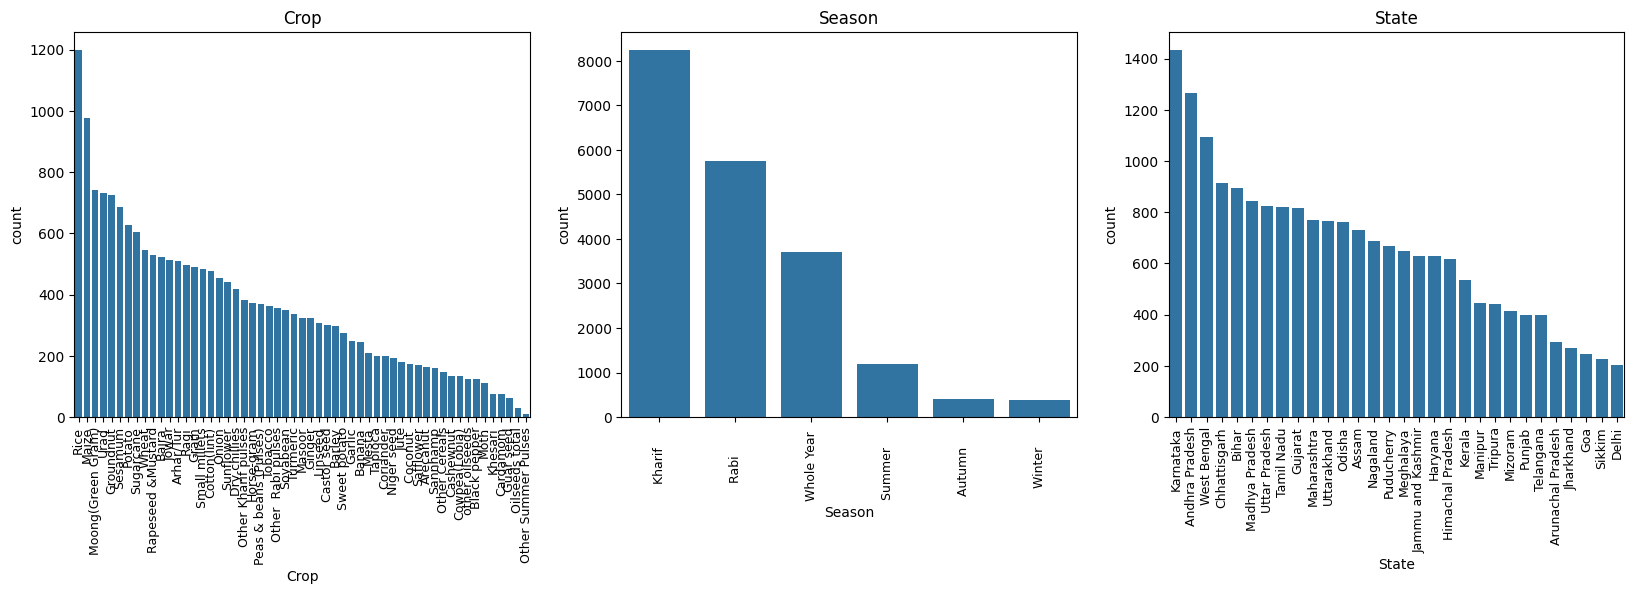

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for column, ax in zip(col_object, axes.ravel()):
    sns.countplot(x=column, data=data, ax=ax, orient="x", order=data[column].value_counts().index)
    ax.set_title(f'{column}', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=9)
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

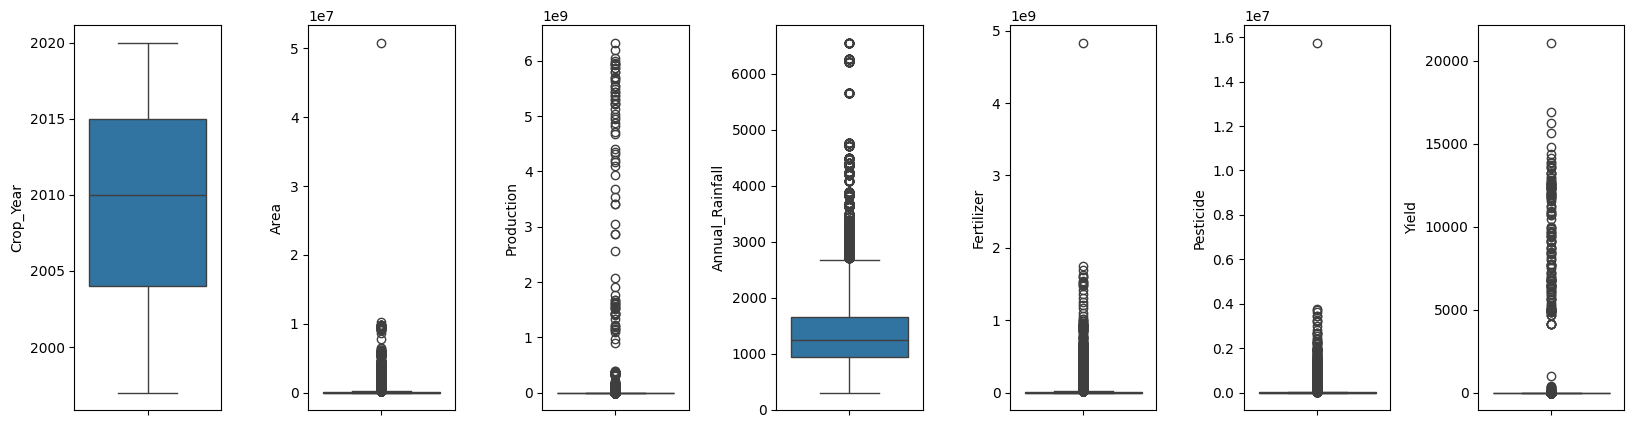

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=len(col_num), figsize=(20,5))

for colum, ax in zip(col_num, axes.ravel()):
    sns.boxplot(data=data[colum], ax=ax)
    #sns.histplot(data.iloc[:,colum], kde=True, ax=ax, bins=20)
    #ax.set_title(f'{colum}', fontsize=12)

plt.subplots_adjust(hspace=0.4, wspace=0.6)

In [8]:
data.Fertilizer.quantile(0.25)

np.float64(188014.62)

In [9]:
def outliers(colum,bound):

    # Calculate IQR
    Q1 = data[colum].quantile(0.25)
    Q3 = data[colum].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - bound * IQR
    upper_bound = Q3 + bound * IQR

    # Identify outliers
    outlier = data[(data[colum] < lower_bound) | (data[colum] > upper_bound)]

    return pd.DataFrame(outlier)

In [10]:
outliers("Fertilizer", 200)

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
110,Niger seed,1997,Rabi,West Bengal,50808100.0,38657300,1852.9,4.835407e+09,15750511.0,0.698889


In [11]:
data = data.drop(110).reset_index(drop=True)

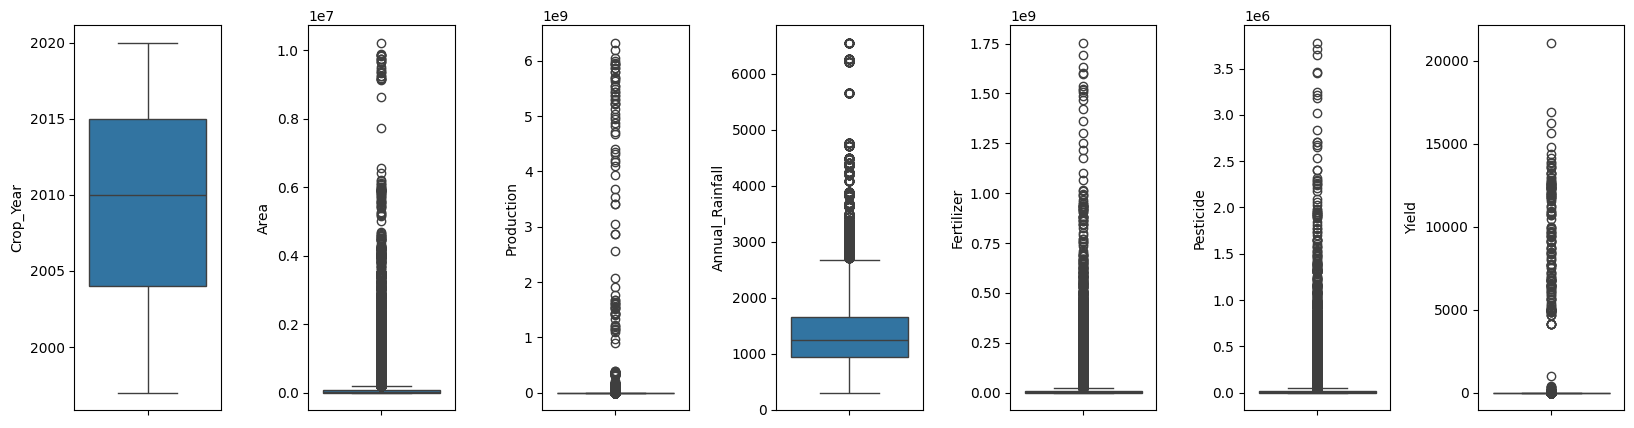

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=len(col_num), figsize=(20,5))

for colum, ax in zip(col_num, axes.ravel()):
    sns.boxplot(data=data[colum], ax=ax)
    #sns.histplot(data.iloc[:,colum], kde=True, ax=ax, bins=20)
    #ax.set_title(f'{colum}', fontsize=12)

plt.subplots_adjust(hspace=0.4, wspace=0.6)

# Encoded and transform

In [13]:
encod = OneHotEncoder(drop=None, sparse_output=False)
encoded_df = encod.fit_transform(data[col_object])
encoded_df = pd.DataFrame(encoded_df, columns=encod.get_feature_names_out(col_object))
data_encoded = pd.concat([data.drop(col_object, axis=1), encoded_df], axis=1)

In [14]:
scal = StandardScaler()
scale_df = scal.fit_transform(data[col_num])
data_encoded[col_num] = scale_df

In [15]:
X = data_encoded

# KMeansClustering

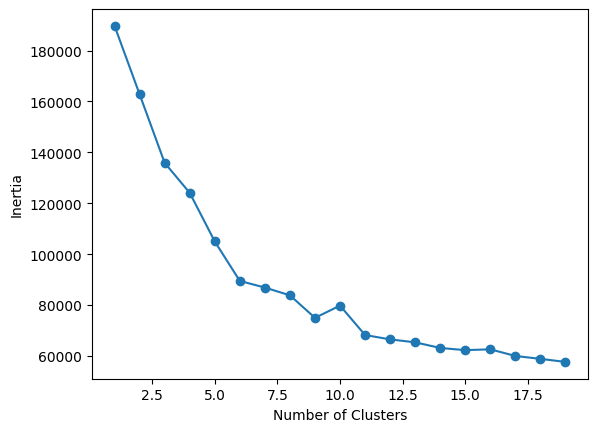

In [16]:
inertia = []
list_num_clusters = list(range(1,20))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
km = KMeans(n_clusters=5, 
            init="k-means++", 
            max_iter=1000, 
            random_state=24)

km.fit(X)

KMeans(max_iter=1000, n_clusters=5, random_state=24)

In [18]:
data_copy = data.copy()

In [19]:
data_copy['labels_KM'] = km.labels_

# Principal Components Analysis

In [20]:
X.shape

(19688, 98)

In [21]:
pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models
for n in range(1, 15):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(X)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 
                               'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': X.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

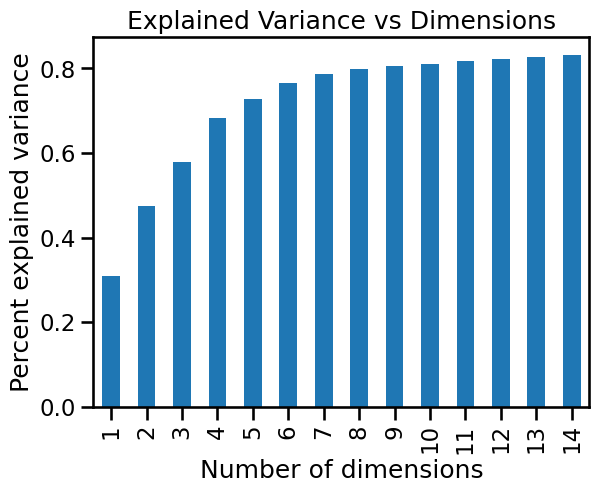

In [22]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions')
plt.show()

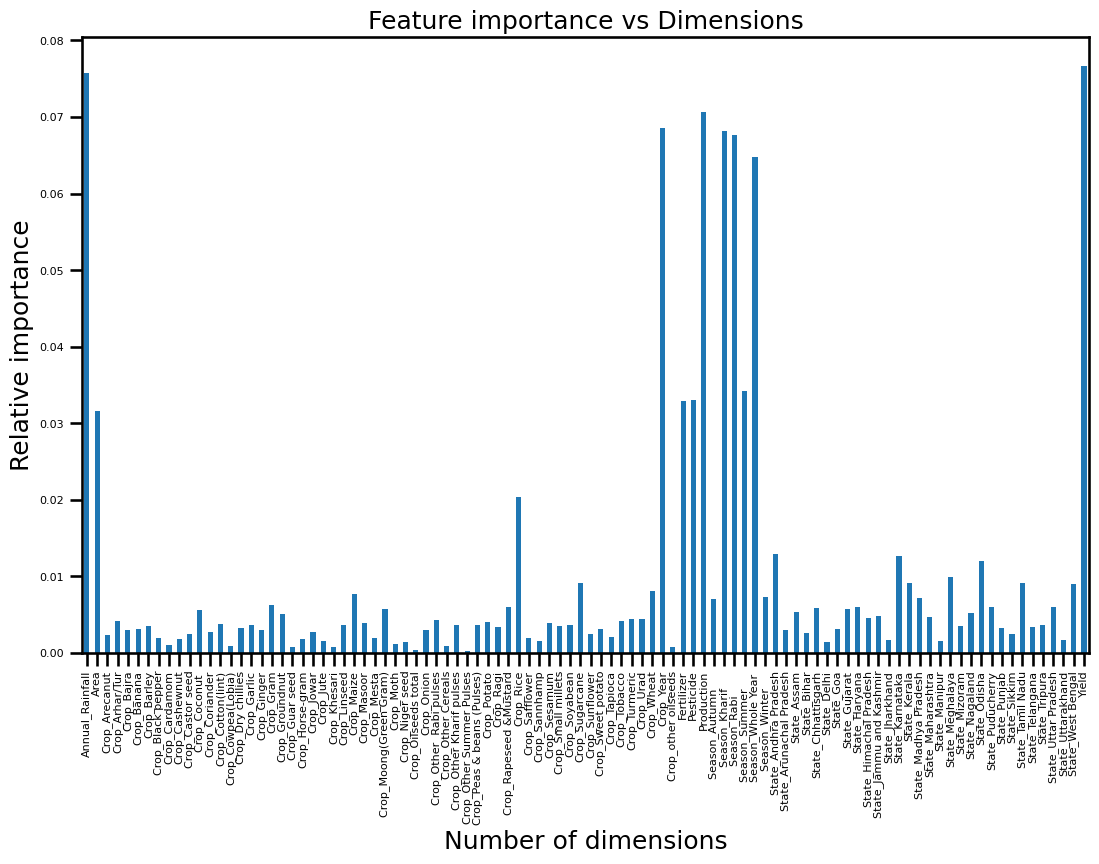

In [23]:
ax = features_df.iloc[7,:].plot(kind='bar', figsize=(13,8))
#ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions')
ax.tick_params(labelsize=8)
plt.show()

In [24]:
PCAmod = PCA(n_components=6)
PCAmod.fit(X)

PCA(n_components=6)

In [25]:
pca_data = PCAmod.transform(X)
df_pca = {}
for i in range(6):
    df_pca['col_'+str(i)] = pca_data[:,i]
df_pca = pd.DataFrame(df_pca)

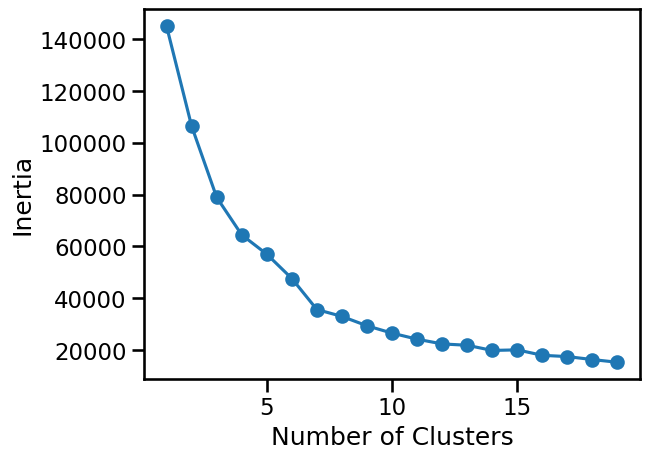

In [26]:
inertia = []
list_num_clusters = list(range(1,20))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(df_pca)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [27]:
km = KMeans(n_clusters=7)
km.fit(df_pca)

KMeans(n_clusters=7)

In [28]:
data_copy["label_KM_PCA"] = km.labels_

In [32]:
data_encoded.to_csv("data_encoded.csv", index=False)
data_copy.to_csv("data_copy.csv", index=False)
df_pca.to_csv("data_pca.csv", index=False)

# Hierarchical Agglomerative Clustering

In [33]:
ag = AgglomerativeClustering(n_clusters=2, 
                             linkage='single', 
                             compute_full_tree=True)
ag = ag.fit(df_pca.to_numpy())
#data['agglom'] = ag.fit_predict(data[float_columns])

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering on the entire dataset
Z = linkage(df, method='ward')

# Plot a truncated version of the dendrogram (showing only the last p merged clusters)
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=30)  # Adjust 'p' as needed
plt.show()


In [34]:
# First, we import the cluster hierarchy module from SciPy (described above) to obtain the linkage and dendrogram functions.
from scipy.cluster import hierarchy

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax)

: 

# PCA Kernel
# Non-negative Matrix Factorization
# DBSCAN
# TSNE
# GMM
# Mean shift
# Multi-Dimensional Scaling